In [1]:
using StateSpaceDynamics, Plots


In [2]:
model = initialize_slds()

SwitchingLinearDynamicalSystem([0.96 0.04; 0.04 0.96], StateSpaceDynamics.LinearDynamicalSystem[StateSpaceDynamics.LinearDynamicalSystem{StateSpaceDynamics.GaussianStateModel{Float64}, StateSpaceDynamics.GaussianObservationModel{Float64}}(StateSpaceDynamics.GaussianStateModel{Float64}([0.9452539570141245 -0.09484174581448675; 0.09484174581448675 0.9452539570141245], [0.001 0.0; 0.0 0.001], [0.0, 0.0], [0.001 0.0; 0.0 0.001]), StateSpaceDynamics.GaussianObservationModel{Float64}([-0.31498797116895605 0.4338858743048611; -0.31125240132442067 -0.3954398407537453; … ; -0.8253345499750688 -0.9654904870197227; 0.840288523245819 0.9656607495563969], [0.001 0.0 … 0.0 0.0; 0.0 0.001 … 0.0 0.0; … ; 0.0 0.0 … 0.001 0.0; 0.0 0.0 … 0.0 0.001]), 2, 10, Bool[1, 1, 1, 1, 1, 1]), StateSpaceDynamics.LinearDynamicalSystem{StateSpaceDynamics.GaussianStateModel{Float64}, StateSpaceDynamics.GaussianObservationModel{Float64}}(StateSpaceDynamics.GaussianStateModel{Float64}([-0.39533949471978524 -0.86383255548

In [3]:
T = 1000
# Generate synthetic data
x, y, z = sample(model, T)


([0.012781148406102944 -0.043551433682513074 … 0.009189945184785569 0.03215941558734649; 0.03788281101630884 -0.021698572664429976 … -0.08498702535863965 -0.10696223889695361], [-0.0037362031674817945 0.011184638740456908 … -0.07094318488635357 -0.05032349162445888; 0.01979088919057409 0.030620168627788782 … 0.03078518538867422 0.0675583423786563; … ; -0.06176123606409473 0.086548578688241 … 0.13735992748512493 0.03213684839745743; 0.042094688716242876 -0.10110240825174423 … -0.0663617447355249 -0.08508079724902799], [2, 2, 2, 2, 2, 2, 2, 2, 2, 2  …  1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

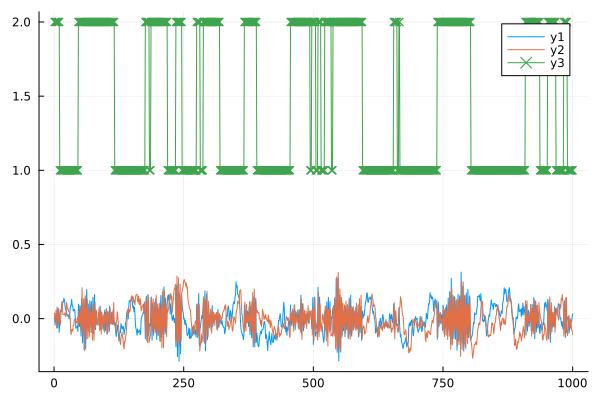

In [4]:
plot(x')
plot!(z, marker=:x)

In [31]:
using LinearAlgebra

p = model.B[1].obs_dim
d = model.B[1].latent_dim

K = model.K
A = [0.9 0.1; 0.2 0.8]
A ./= sum(A, dims=2) # Normalize rows to sum to 1

πₖ = rand(K)
πₖ ./= sum(πₖ) # Normalize to sum to 1

Q = Matrix(0.5 * I(d))

x0 = [0.0; 0.0]
P0 = Matrix(0.5 * I(d))

# set up the observation parameters
C = randn(p, d)
R = Matrix(0.5 * I(p))

#C = model.B[1].obs_model.C
#R = model.B[1].obs_model.R

B = [StateSpaceDynamics.LinearDynamicalSystem(
    StateSpaceDynamics.GaussianStateModel(0.95 * [cos(f) -sin(f); sin(f) cos(f)], Q, x0, P0),
    StateSpaceDynamics.GaussianObservationModel(C, R),
    d, p, fill(true, 6  )) for (i,f) in zip(1:K, [0.5, 0.5])]

#B = [StateSpaceDynamics.LinearDynamicalSystem(
#    StateSpaceDynamics.GaussianStateModel(model.B[i].state_model.A, model.B[i].state_model.Q, x0, P0),
#    StateSpaceDynamics.GaussianObservationModel(C, R),
#    d, p, fill(true, 6  )) for (i,f) in zip(1:K, [0.5, 0.5])]

modeli = SwitchingLinearDynamicalSystem(A, B, πₖ, model.K)

SwitchingLinearDynamicalSystem([0.9 0.1; 0.2 0.8], StateSpaceDynamics.LinearDynamicalSystem[StateSpaceDynamics.LinearDynamicalSystem{StateSpaceDynamics.GaussianStateModel{Float64}, StateSpaceDynamics.GaussianObservationModel{Float64}}(StateSpaceDynamics.GaussianStateModel{Float64}([0.8337034337958541 -0.45545426167399283; 0.45545426167399283 0.8337034337958541], [0.5 0.0; 0.0 0.5], [0.0, 0.0], [0.5 0.0; 0.0 0.5]), StateSpaceDynamics.GaussianObservationModel{Float64}([-1.9354759476312569 -0.029897879793919894; -0.6216648018759413 -0.7000455209543301; … ; 0.1271760215776717 -0.5825941843794515; 0.5010851049679077 1.0272539162368985], [0.5 0.0 … 0.0 0.0; 0.0 0.5 … 0.0 0.0; … ; 0.0 0.0 … 0.5 0.0; 0.0 0.0 … 0.0 0.5]), 2, 10, Bool[1, 1, 1, 1, 1, 1]), StateSpaceDynamics.LinearDynamicalSystem{StateSpaceDynamics.GaussianStateModel{Float64}, StateSpaceDynamics.GaussianObservationModel{Float64}}(StateSpaceDynamics.GaussianStateModel{Float64}([0.8337034337958541 -0.45545426167399283; 0.45545426167

In [32]:
model.A

2×2 Matrix{Float64}:
 0.96  0.04
 0.04  0.96

In [33]:
modeli.A

2×2 Matrix{Float64}:
 0.9  0.1
 0.2  0.8

In [34]:
K = modeli.K
T_step = size(y, 2)
FB = StateSpaceDynamics.initialize_forward_backward(modeli, T_step)
FS = [StateSpaceDynamics.initialize_FilterSmooth(model.B[k], T_step) for k in 1:K]
ml = zeros(10)

for i in 1:length(ml)
    ml[i] = variational_expectation!(modeli, y, FB, FS)   
end

In [35]:
ml

10-element Vector{Float64}:
  -178.96464196673975
 -1430.6096128800652
 -1121.1497991617625
 -1101.782048112277
 -1101.7432276987665
 -1101.7428310176422
 -1101.7428301485943
 -1101.7428301467314
 -1101.7428301467273
 -1101.7428301467273

In [36]:
diff(ml) .>= 0

9-element BitVector:
 0
 1
 1
 1
 1
 1
 1
 1
 1

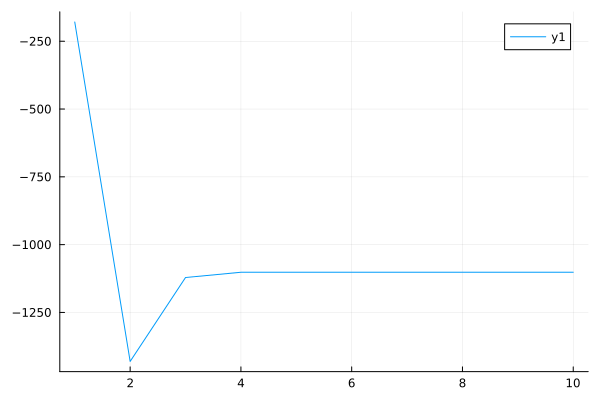

In [37]:
plot(ml)

In [38]:
mls, param_diff, FB, FS = fit!(modeli, y; max_iter=10)

CompositeException: TaskFailedException

    nested task error: PosDefException: matrix is not positive definite; Cholesky factorization failed.
    Stacktrace:
     [1] checkpositivedefinite
       @ ~/.julia/juliaup/julia-1.10.4+0.aarch64.apple.darwin14/share/julia/stdlib/v1.10/LinearAlgebra/src/factorization.jl:67 [inlined]
     [2] cholesky!(A::Symmetric{Float64, Matrix{Float64}}, ::NoPivot; check::Bool)
       @ LinearAlgebra ~/.julia/juliaup/julia-1.10.4+0.aarch64.apple.darwin14/share/julia/stdlib/v1.10/LinearAlgebra/src/cholesky.jl:269
     [3] cholesky! (repeats 2 times)
       @ ~/.julia/juliaup/julia-1.10.4+0.aarch64.apple.darwin14/share/julia/stdlib/v1.10/LinearAlgebra/src/cholesky.jl:267 [inlined]
     [4] cholesky(A::Symmetric{Float64, Matrix{Float64}}, ::NoPivot; check::Bool)
       @ LinearAlgebra ~/.julia/juliaup/julia-1.10.4+0.aarch64.apple.darwin14/share/julia/stdlib/v1.10/LinearAlgebra/src/cholesky.jl:401
     [5] cholesky (repeats 2 times)
       @ ~/.julia/juliaup/julia-1.10.4+0.aarch64.apple.darwin14/share/julia/stdlib/v1.10/LinearAlgebra/src/cholesky.jl:401 [inlined]
     [6] macro expansion
       @ ~/Documents/GitHub/StateSpaceDynamics.jl/src/SLDS.jl:290 [inlined]
     [7] (::StateSpaceDynamics.var"#224#threadsfor_fun#58"{StateSpaceDynamics.var"#224#threadsfor_fun#56#59"{Vector{StateSpaceDynamics.GaussianObservationModel{Float64}}, StateSpaceDynamics.ForwardBackward{Float64}, Matrix{Float64}, Vector{StateSpaceDynamics.FilterSmooth{Float64}}, Int64, UnitRange{Int64}}})(tid::Int64; onethread::Bool)
       @ StateSpaceDynamics ./threadingconstructs.jl:215
     [8] #224#threadsfor_fun
       @ ./threadingconstructs.jl:182 [inlined]
     [9] (::Base.Threads.var"#1#2"{StateSpaceDynamics.var"#224#threadsfor_fun#58"{StateSpaceDynamics.var"#224#threadsfor_fun#56#59"{Vector{StateSpaceDynamics.GaussianObservationModel{Float64}}, StateSpaceDynamics.ForwardBackward{Float64}, Matrix{Float64}, Vector{StateSpaceDynamics.FilterSmooth{Float64}}, Int64, UnitRange{Int64}}}, Int64})()
       @ Base.Threads ./threadingconstructs.jl:154

In [13]:
param_diff

10-element Vector{Float64}:
 0.9990595595273674
 0.01868629838357508
 0.011458418539642277
 0.008155367472803677
 0.00632474511123267
 0.005623396968370176
 0.005714609355228956
 0.006130289114612445
 0.006569080621523132
 0.006918406769872443

In [14]:
model.A

2×2 Matrix{Float64}:
 0.96  0.04
 0.04  0.96

In [15]:
modeli.A

2×2 Matrix{Float64}:
 0.965742   0.0342577
 0.0544041  0.945596

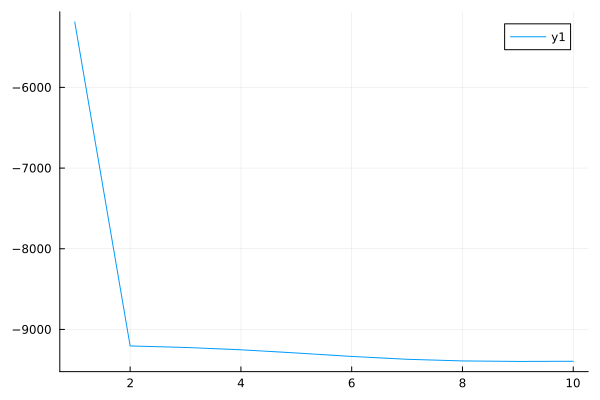

In [16]:
plot(mls)

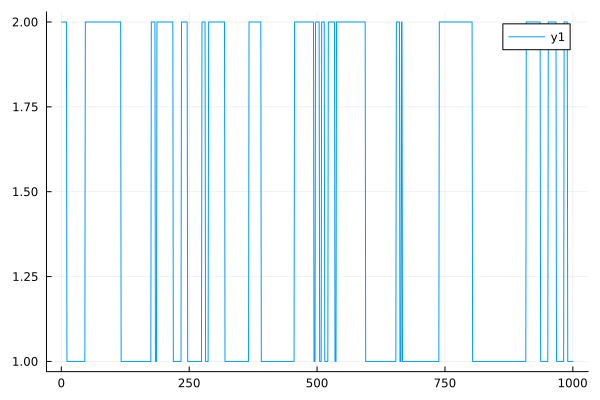

In [17]:
plot(z)

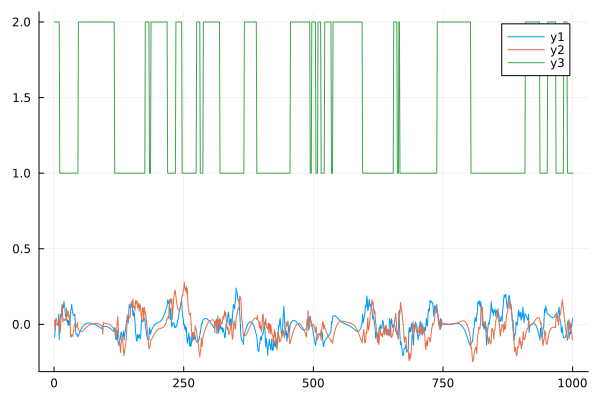

In [18]:
plot(FS[1].x_smooth')
plot!(z)

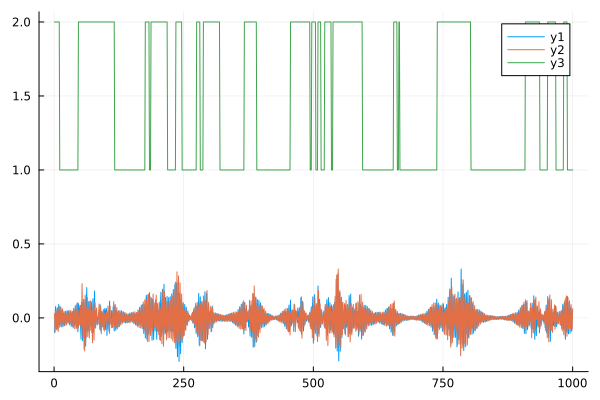

In [19]:
plot(FS[2].x_smooth')
plot!(z)

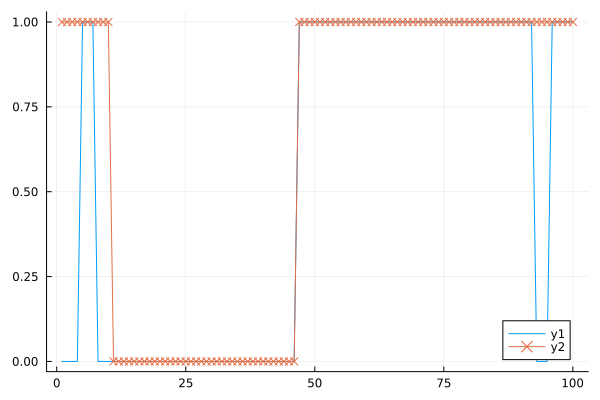

In [20]:
plot(exp.(FB.γ)'[1:100,2])
plot!(z[1:100] .- 1, marker=:x)

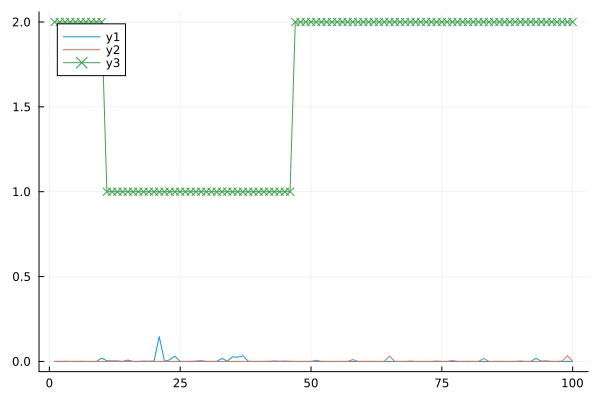

In [21]:
plot(exp.(FB.loglikelihoods[:,1:100])')
plot!(z[1:100], marker=:x)

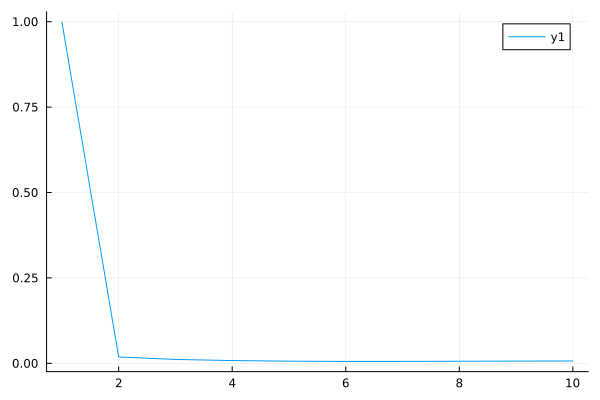

In [22]:
plot(param_diff)